In [1]:
import re
from pybedtools import BedTool

class CpgIslands:
    def __init__(self, cpg_line):
        self.cpg_list = cpg_line.rstrip().split("\t")
        self.start, self.end = [int(each) for each in self.cpg_list[2:4]]
        self.chr = self.cpg_list[1]
        self.out_list = self.cpgIsland()
    
    def cpgIsland(self):
        cpg = [self.chr, str(self.start), str(self.end)]
        out_list = [cpg]
        return out_list

class Shores:
    def __init__(self, cpg_line):
        self.cpg_list = cpg_line.rstrip().split("\t")
        self.start, self.end = [int(each) for each in self.cpg_list[1:3]]
        self.chr = self.cpg_list[0]
        self.out_list = self.shore()
    
    def shore(self):
        shores = [self.chr, str(self.start - 2000), str(self.end + 2000)]
        out_list = [shores]
        return out_list

class Shelves:
    def __init__(self, shore_line):
        self.shore_list = shore_line.rstrip().split("\t")
        self.start, self.end = [int(each) for each in self.cpg_list[1:3]]
        self.chr = self.shore_list[0]
        self.out_list = self.shelf()
    
    def shelf(self):
        shelves = [self.chr, str(self.start - 2000), str(self.end + 2000)]
        out_list = [shelves]
        return out_list

class Seas:
    pass

def cpg_island_bed():
    in_link = open("cpgIslandExt.txt", "r")
    cpg_island = open("cpg_island.bed", "w")
    cpgi = ""
    for cpg_line in in_link:
        CpgObj = CpgIslands(cpg_line)
        cpg = CpgObj.out_list[0]
        m = re.search(r'\d+', cpg[0])
        if m is not None:
            if cpg[0] == "chr" + m.group():
                cpgi = "\t".join(cpg) + "\n"
                cpg_island.write(cpgi)
    in_link.close()
    cpg_island.close()
    
def shores_bed():    
    cpg_island = BedTool("cpg_island.bed")
    cpg = cpg_island.merge()
    cpgi = open("cpg_island.bed", "w")
    cpgi.write(str(cpg))
    cpgi.close()
    
    in_link = open("cpg_island.bed", "r")
    shores = open("shores.bed", "w")
    shore = ""
    
    for cpg_line in in_link:
        ShoreObj = Shores(cpg_line)
        shr = ShoreObj.out_list[0]
        shore = "\t".join(shr) + "\n"
        shores.write(shore)
    in_link.close()
    shores.close()

def shelves_bed():
    cpg_island = BedTool("cpg_island.bed")
    shores = BedTool("shores.bed")
    shore = shores.merge()
    shores = shore.subtract(cpg_island)
    shr = open("shores.bed", "w")
    shr.write(str(shores))
    shr.close()
    
    in_link = open("shores.bed", "r")
    shelves = open("shelves.bed", "w")
    stemp = open("shelf.bed", "w")
    shelf = ""
    
    for shore_line in in_link:
        ShelvesObj = Shores(shore_line)
        shelve = ShelvesObj.out_list[0]
        shelf = "\t".join(shelve) + "\n"
        shelves.write(shelf)
        stemp.write(shelf)
    in_link.close()
    shelves.close()
    stemp.close()
    
def seas_bed():
    cpg_island = BedTool("cpg_island.bed")
    shores = BedTool("shores.bed")
    shelves = BedTool("shelves.bed")
    shef = BedTool("shelf.bed")
    shef = shef.merge()
    shelves = shelves.merge()
    shelves = shelves.subtract(shores)
    shelves = shelves.subtract(cpg_island)
    sh=open("shelf.bed","w")
    shelf = open("shelves.bed", "w")
    shelf.write(str(shelves))
    sh.write(str(shef))
    sh.close()
    shelf.close()
    
    size = BedTool("size.bed")
    shlf = BedTool("shelf.bed")
    seas = size.subtract(shlf)
    sea = open("seas.bed", "w")
    sea.write(str(seas))
    sea.close()
    

In [2]:
cpg_island_bed()
shores_bed()
shelves_bed()
seas_bed()

In [3]:
class MethylationMiddle:
    def __init__(self, m_line):
        self.m_list = m_line.rstrip().split("\t")
        self.start, self.end = [int(each) for each in self.m_list[1:3]]
        self.chr = self.m_list[0]
        self.out_list = self.find_middle()
    
    def find_middle(self):
        dna_methyl_middle = [self.chr, str(self.start), str((self.start + self.end) // 2)]
        return dna_methyl_middle

def methyl_middle_bed():
    dna_methylation = open("dnamethyl.bed", "r")
    methyl = open("methylMiddle.bed", "w")
    for m_line in dna_methylation:
        mObj = MethylationMiddle(m_line)
        m = "\t".join(mObj.out_list) + "\n"
        methyl.write(m)
    methyl.close()

In [4]:
methyl_middle_bed()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(methylation_cpg_island, methylation_shores, methylation_shelves, methylation_seas, lbl):
    objects = ('cpg islands', 'shores', 'shelves', 'seas')
    y_pos = np.arange(len(objects))
    performance = [methylation_cpg_island, methylation_shores, methylation_shelves, methylation_seas]
    plt.bar(y_pos,performance)
    plt.xticks(y_pos, objects)
    plt.ylabel(lbl)
    plt.title('DNA methylations in CPG Islands, Shores, Shelves, Seas')
    plt.show()

def count_methylation():
    dna_methylation = BedTool("methylMiddle.bed")
    cpgi = BedTool("cpg_island.bed")
    shore = BedTool("shores.bed")
    shelf = BedTool("shelves.bed")
    sea = BedTool("seas.bed")
    methylation_cpg_island = cpgi.intersect(dna_methylation).count()
    methylation_shores = shore.intersect(dna_methylation).count()
    methylation_shelves = shelf.intersect(dna_methylation).count()
    methylation_seas = sea.intersect(dna_methylation).count()
    total = len(dna_methylation)
    percentage_methyl_cpgi = (methylation_cpg_island * 100) // total
    percentage_methyl_shores = (methylation_shores * 100) // total
    percentage_methyl_shelves = (methylation_shelves * 100) // total
    percentage_methyl_seas = (methylation_seas * 100) // total
    
    plot_bar(percentage_methyl_cpgi, percentage_methyl_shores, percentage_methyl_shelves, percentage_methyl_seas, '% methylations')
    plot_bar(methylation_cpg_island, methylation_shores, methylation_shelves, methylation_seas, '# methylations')
    
    

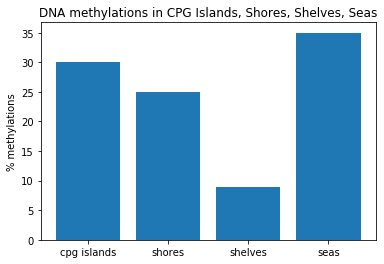

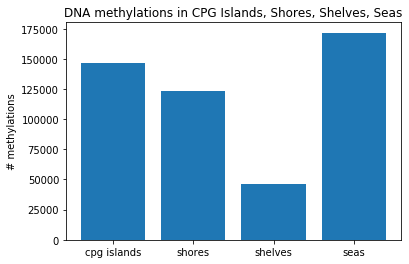

In [10]:
count_methylation()